# **Лабораторная работа 2**
*Naumov Anton (Any0019)*

*To contact me in telegram: @any0019*

В данном задании вашей задачей будет построить и обучить модель CycleGAN для задачи Img2Img.

---

Про задачу __Img2Img__:

- У вас есть 2 множества изображений ($A$ и $B$)
- Ваша задача - научиться превращать изображения из множества $A$ в изображения из множества $B$ и наоборот
- Бывают paired и unpaired множества
- В случае __paired__ множеств - для каждого изображения из $A$ существует конкретное изображение из $B$, в которое оно должно перейти (и наоборот). Примером такой пары множеств может быть (а) спутниковая фотграфия местности vs схематическая карта местности , (б) фотография фасада здания vs схема фасада здания , ...
- В случае __unpaired__ множеств - между множествами нет конкретных пар. Примером такой пары множеств может быть (а) фотографии с лошадьми vs фотографии с зебрами , (б) фотографии vs рисунки конкретного художника , ...

---

Про модель __CycleGAN__:

- Модель придумана для задачи Img2Img (в первую очередь unpaired версии) и основана на концепции GAN-ов
- В модели есть 2 генератора: $G_{A -> B}$ (задача которого - принимая на вход изображение из множества $A$ переводить его в изображение из множества $B$) и $G_{B -> A}$ (аналогично в другую сторону)
- Надо отметить что на вход генераторы не получают никакую дополнительную случайность, что делает обучение таких моделей проще
- В модели так же есть 2 дискриминатора: $D_{A}$ (задача которого - отличать реальные изображения из $A$ от сгенерированных с помощью $G_{B -> A}$ изображений) и $D_{B}$ (аналогично для $B$)
- Функцией ошибки будет, как и для GAN-ов, minmax игра между генераторами и дискриминаторами, но к ошибке генераторов добавится ещё и, так называемый, `cycle consistency loss`, который проверяет, что после двойного перехода изображения не меняются $G_{B -> A} \big( G_{A -> B} ( a ) \big) = a ; \forall a \in A$ и $G_{A -> B} \big( G_{B -> A} ( b ) \big) = b ; \forall b \in B$
- Так же можно добавлять или нет штраф за то, чтобы $G_{B -> A}$ не меняла изображения из $A$ и наоборот $G_{A -> B}$ не меняла изображения из $B$
- Оригинальная статья: https://arxiv.org/pdf/1703.10593.pdf

---

Ваша задача - ноутбук разбит на несколько частей, каждая со своими баллами

1. __Подготовка данных__ _(2 балла)_ --> требуется выбрать датасет для обучения (дано несколько на выбор) и составить пайплайн подготовки данных
2. __Составление модели__ _(6 баллов)_ --> требуется собрать нейросеть _(3 балла)_ и создать функции ошибки _(3 балла)_
3. __Подготовка обучения__ _(2 балла)_ --> требуется написать шаги обучения и валидации, визуализацию, а так же полный цикл обучения
4. __Обучение__ _(2 балла)_ --> требуется обучить модель
5. __Сбор своего датасета и обучение модели на нём__ _(3 балла)_ --> требуется собрать свой датасет и обучить на нём модель

***За наиболее интересные и качественные решения в пункте 5 так же предусмотрены дополнительные баллы***

In [1]:
from typing import Iterator

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter

from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms as tr

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Для тёмной темы jupyter - уберите если не нужно
plt.style.use('dark_background')

from tqdm.auto import tqdm, trange

import os
import sys
import requests
import cv2
from PIL import Image

from dataclasses import dataclass

In [2]:
# !apt install unzip
!ls
# !unzip /content/download.zip -d /content/download
!tar -xvf  'content/download.tar.gz' -C 'content/download'

answer_1.json			 lab_2_ML2_ic_student.ipynb
demand-forecasting-kernels-only  lab_3_ML2_paper_referat.ipynb
download			 lab_4_ML2_cycle_gan_student.ipynb
download.tar.gz			 lab_5_markdown-image.jpeg
download.zip			 lab_5_ML2_time_series.ipynb
gan				 lab_6_ML2_time_series.ipynb
hws.zip				 notmnist.py
lab_1_ML2_pytorch.ipynb
tar: content/download.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


# 1. Подготовка данных (___2 балла___)

## 1.1 Выбор и скачивание датасета

In [3]:
dataset_folder = "./download/img2img"
num_images_per_split = 5

os.environ["dataset_folder"] = dataset_folder
!mkdir -p {dataset_folder}

# В этом цикле каждый из предложенных датасетов
#  - скачивается
#  - распаковывается
#  - отрисовывается + meta
#  - удаляется

# Предлагается посмотреть на все предложенные варианты датасетов и затем оставить один,
#  с которым захочется работать больше всего - закомментируйте (или удалите) все, кроме
#  выбранного, а так же закомментируйте строчки с удалением скачанного датасета
for dataset_name in [
    # Unpaired
    # "apple2orange",
    # "summer2winter_yosemite",
    # "horse2zebra",
    # "monet2photo",
    # "cezanne2photo",
    # "ukiyoe2photo",
    # "vangogh2photo",
    # # Paired
    # "maps",
    # "facades",
]:
    print(f"Dataset '{dataset_name}'")
    url = f"http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/{dataset_name}.zip"
    download_path = os.path.join(dataset_folder, f"{dataset_name}.zip")
    target_folder = os.path.join(dataset_folder, dataset_name)

    # Чтобы bash вызовы знали соответствующие переменные
    os.environ["url"] = url
    os.environ["download_path"] = download_path
    os.environ["target_folder"] = target_folder

    print("Loading zip file...", end="")
    # Проверяем что нет такого загруженого файла
    if not os.path.isfile(download_path) or os.path.exists(target_folder):
        # # Можно загрузить через requests библиотеку
        # response = requests.get(url)
        # open(download_path, "wb").write(response.content)

        # Можно загрузить через wget
        !wget {url} -O {download_path}
    print(" --> done!")

    print("Unziping...", end="")
    # Распаковываем
    if os.path.exists(target_folder):
        !rm -r {target_folder}
    !mkdir -p {dataset_folder}
    !unzip -qq {download_path} -d {dataset_folder}
    print(" --> done!")

    # Удаляем zip-файл
    !rm {download_path}

    # Meta + Отрисовка
    print(f"Provided splits: {os.listdir(target_folder)}")
    # Удобный способ быстро получить датасет картинок с лэйблами, если картинки разложены по папкам в формате:
    # root_folder/label_name/img.jpg
    # (в нашем случае нет лэйблов, но картинки разложены в таком же формате, просто вместо label_name идёт
    #  split_name: trainA/testA/trainB/testB)
    dataset = datasets.ImageFolder(target_folder)

    inds_to_show = {i: [] for i, _ in enumerate(dataset.classes)}
    classes_full = 0
    for dataset_ind in range(len(dataset)):
        _, split_ind = dataset[dataset_ind]
        if len(inds_to_show[split_ind]) == num_images_per_split:
            continue
        inds_to_show[split_ind].append(dataset_ind)
        if len(inds_to_show[split_ind]) == num_images_per_split:
            classes_full += 1
        if classes_full == len(dataset.classes):
            break

    for split_name in sorted(dataset.classes):
        split_ind = dataset.class_to_idx[split_name]
        print(f"Split '{split_name}' of dataset '{dataset_name}'", end="")
        split_folder = os.path.join(target_folder, split_name)
        print(f" --> size: {len(os.listdir(split_folder))}")

        plt.subplots(1, num_images_per_split, figsize=(5 * num_images_per_split, 5))
        plt.suptitle(f"{dataset_name} ~ {split_name}", y=0.95)
        for i, dataset_ind in enumerate(inds_to_show[split_ind]):
            plt.subplot(1, num_images_per_split, i + 1)
            plt.imshow(dataset[dataset_ind][0])
            plt.xticks([])
            plt.yticks([])
        plt.show()

    # Удаляем скачанный датасет
    # !rm -r {target_folder}

    print("\n----------------------------\n")

## 1.2 Dataset и Transforms

В папке `target_folder` находятся несколько папок со сплитами для соответствующего датасета, в каждой папке сплита находятся сами `.jpg` изображения.

Давайте составим их в удобном для нас виде в отдельные датасеты для каждого сплита без лэйблов.

Для получения картинок можно использовать
```python
cv2.imread(img_path)[:, :, ::-1]  # каналы записаны в обратном порядке
```

In [4]:
# !pwd
!ls ./download/img2img

monet2photo


In [5]:

# Выбранный выше и скачанный датасет
dataset_folder = "./download/img2img"
dataset_name = "monet2photo"
target_folder = os.path.join(dataset_folder, dataset_name)

# Класс для датасета изображений без лэйблов с применением трансформов
class ImageDatasetNoLabel(Dataset):
    def __init__(self, path, transforms=None):
        super(ImageDatasetNoLabel).__init__()
        self.path = path
        self.transform = transforms
        self.image_list = os.listdir(path)

    def __getitem__(self, index):
        img_path = self.image_list[index]
        img = Image.open(self.path + "/" + img_path)
        if self.transform:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.image_list)

# Удобный класс для хранения всех наших датасетов
@dataclass
class DatasetsClass:
    train_a: ImageDatasetNoLabel
    train_b: ImageDatasetNoLabel
    test_a: ImageDatasetNoLabel
    test_b: ImageDatasetNoLabel


# Все датасеты без трансформов - чтобы посчитать статистики
ds = DatasetsClass(
    train_a=ImageDatasetNoLabel(os.path.join(target_folder, "trainA")),
    train_b=ImageDatasetNoLabel(os.path.join(target_folder, "trainB")),
    test_a=ImageDatasetNoLabel(os.path.join(target_folder, "testA")),
    test_b=ImageDatasetNoLabel(os.path.join(target_folder, "testB")),
)

In [6]:

def get_channel_statistics(dataset):
    """
    Функция для получения поканальных статистик (среднее и отклонение) по датасету
    """
    to_tensor = tr.ToTensor()
    channel_sum = 0
    sqr_channel_sum = 0
    for i in dataset:
        img = to_tensor(i)
        channel_sum += img.view(3, -1).mean(1)
        sqr_channel_sum += img.view(3, -1).mean(1)
    channel_mean = channel_sum / len(dataset)
    channel_std = torch.sqrt(sqr_channel_sum / len(dataset) - channel_mean**2)
    return channel_mean, channel_std

# Поканальное среднее и отклонение для A
channel_mean_a, channel_std_a = get_channel_statistics(ds.train_a)
print(channel_mean_a, channel_std_a)

# Поканальное среднее и отклонение для B
channel_mean_b, channel_std_b = get_channel_statistics(ds.train_b)
print(channel_mean_b, channel_std_b)

tensor([0.5199, 0.5115, 0.4722]) tensor([0.4996, 0.4999, 0.4992])
tensor([0.4123, 0.4093, 0.3927]) tensor([0.4922, 0.4917, 0.4883])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


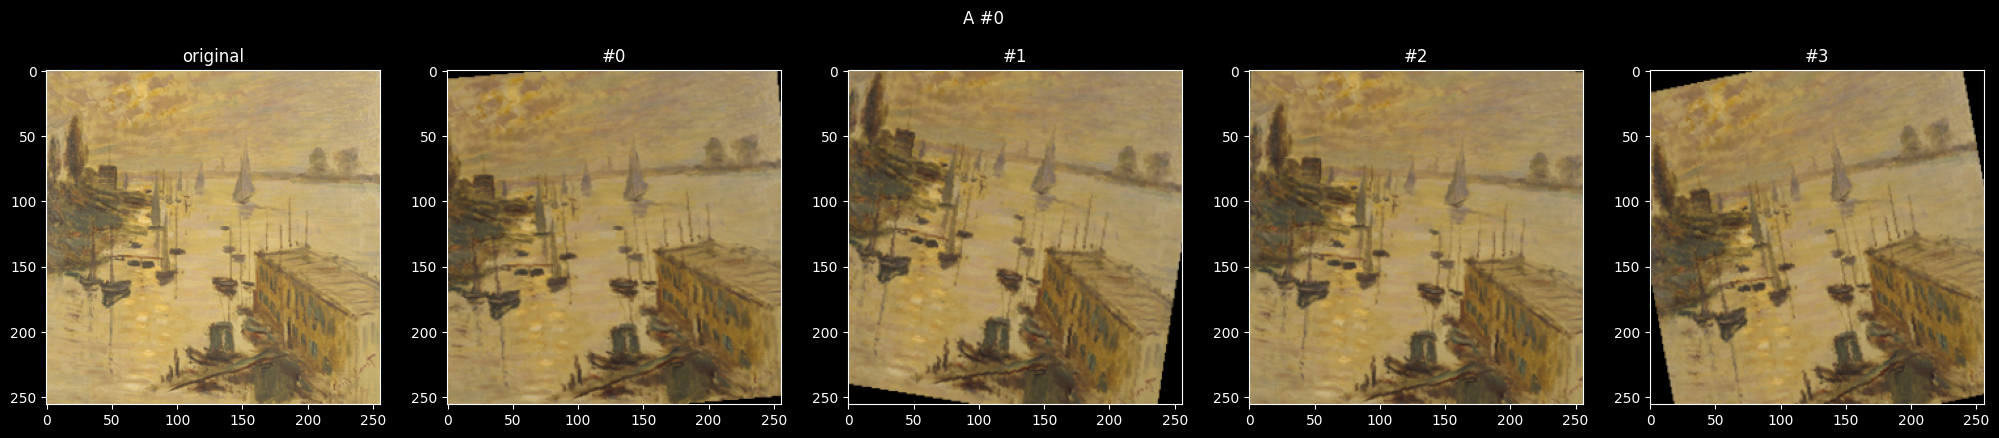

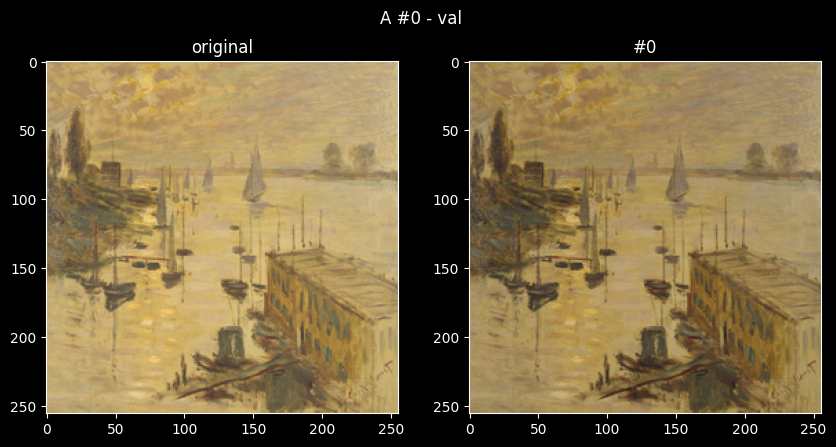

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


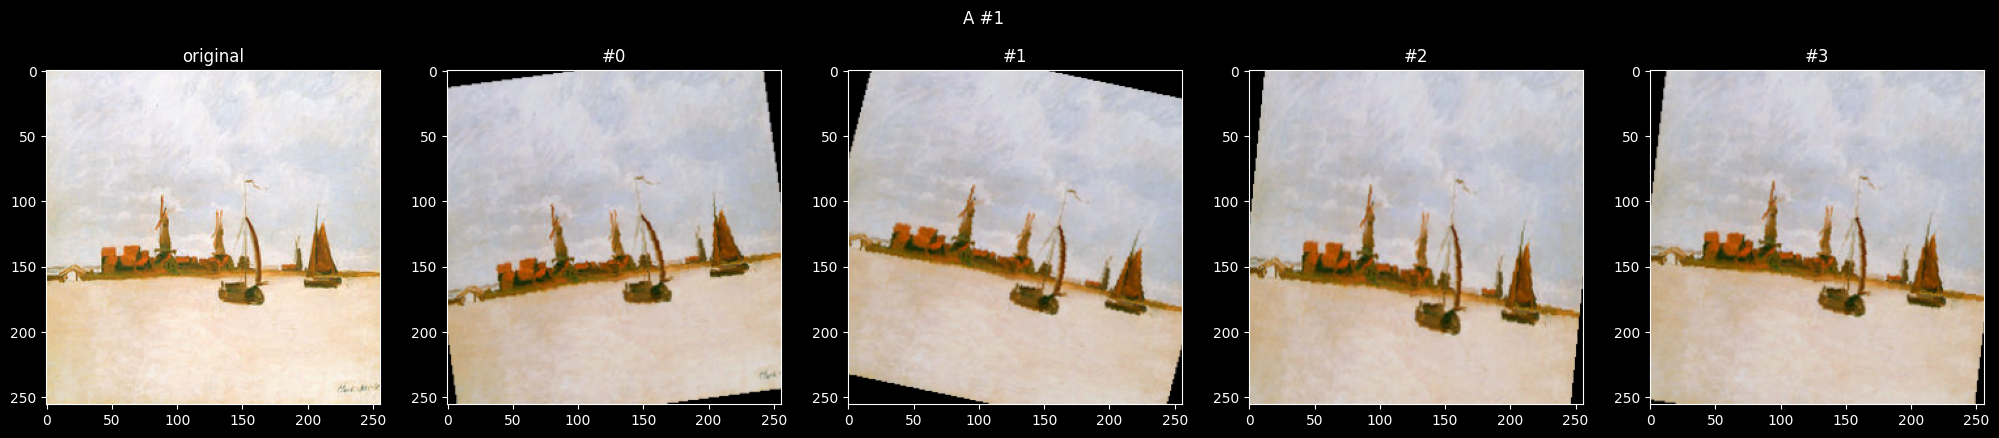

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


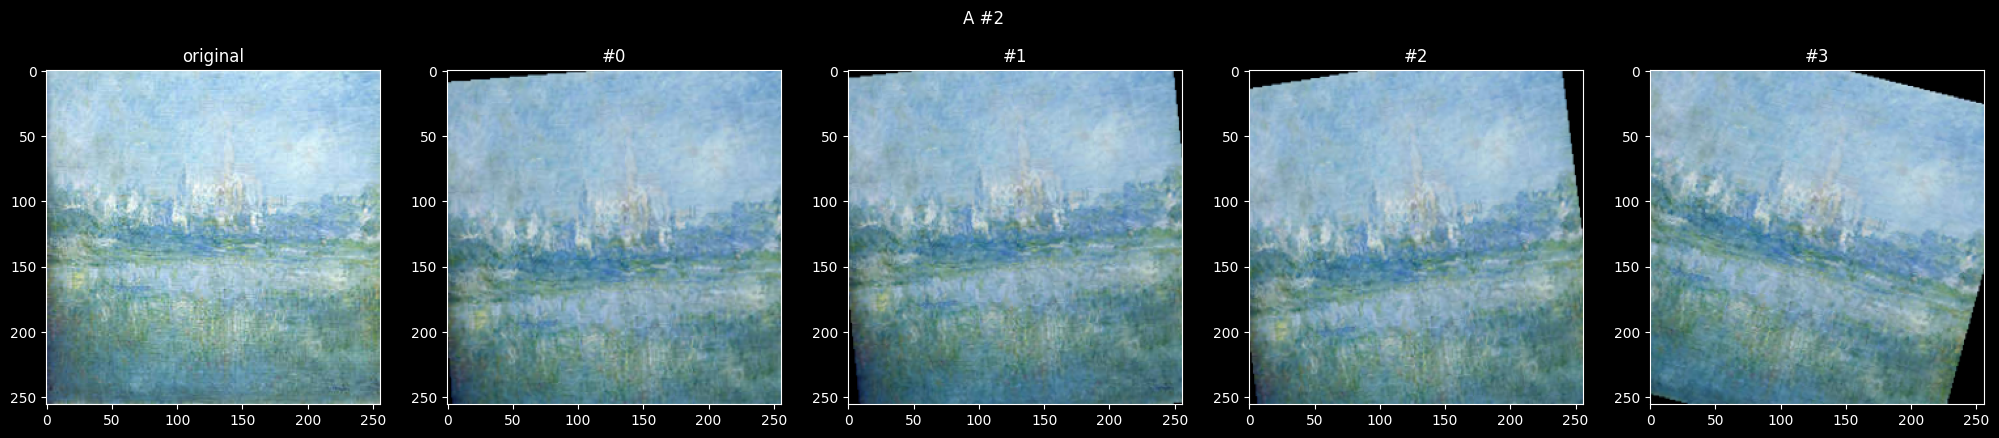

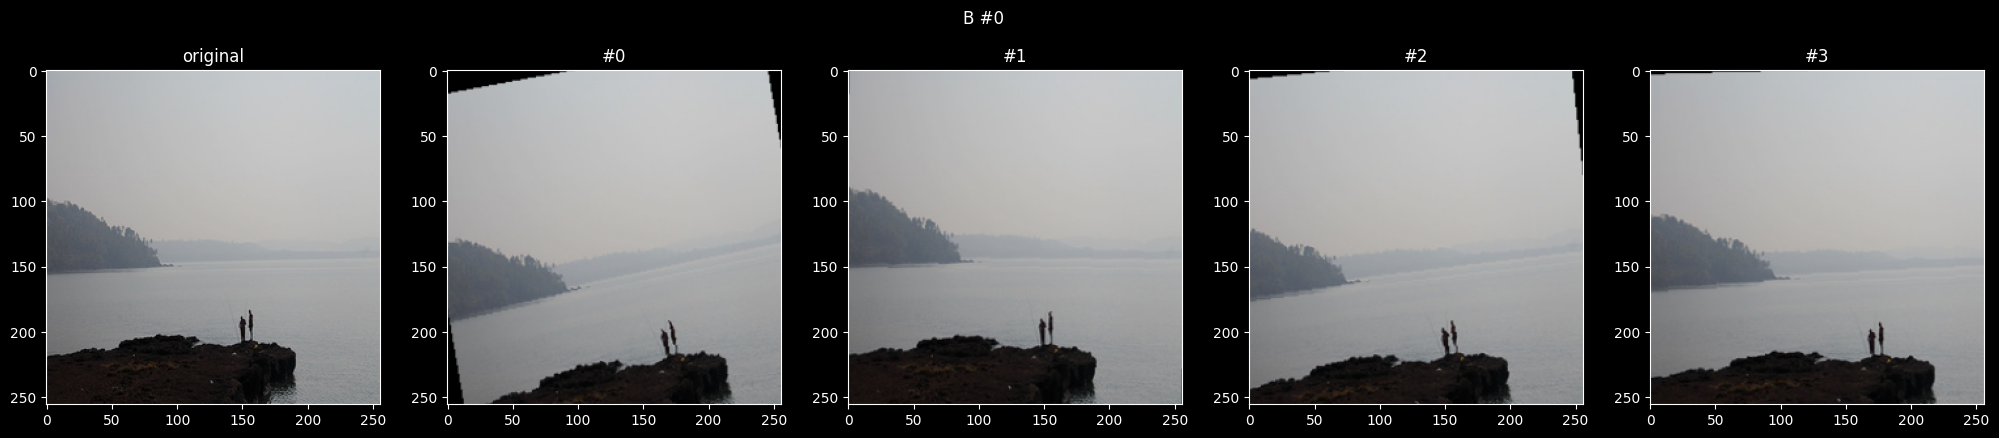

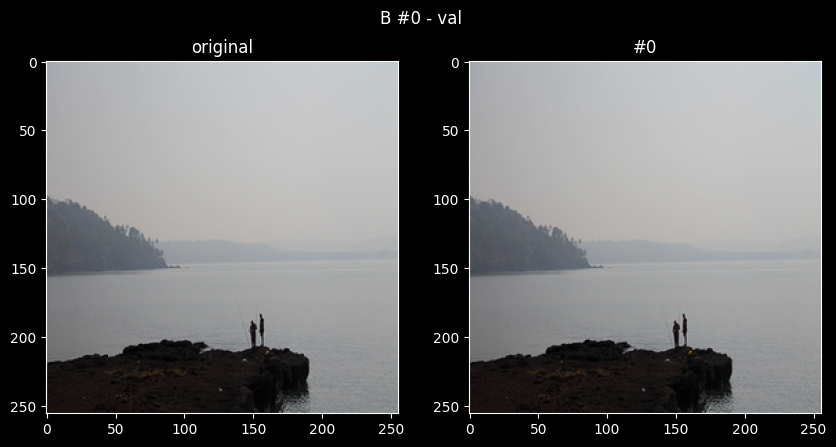

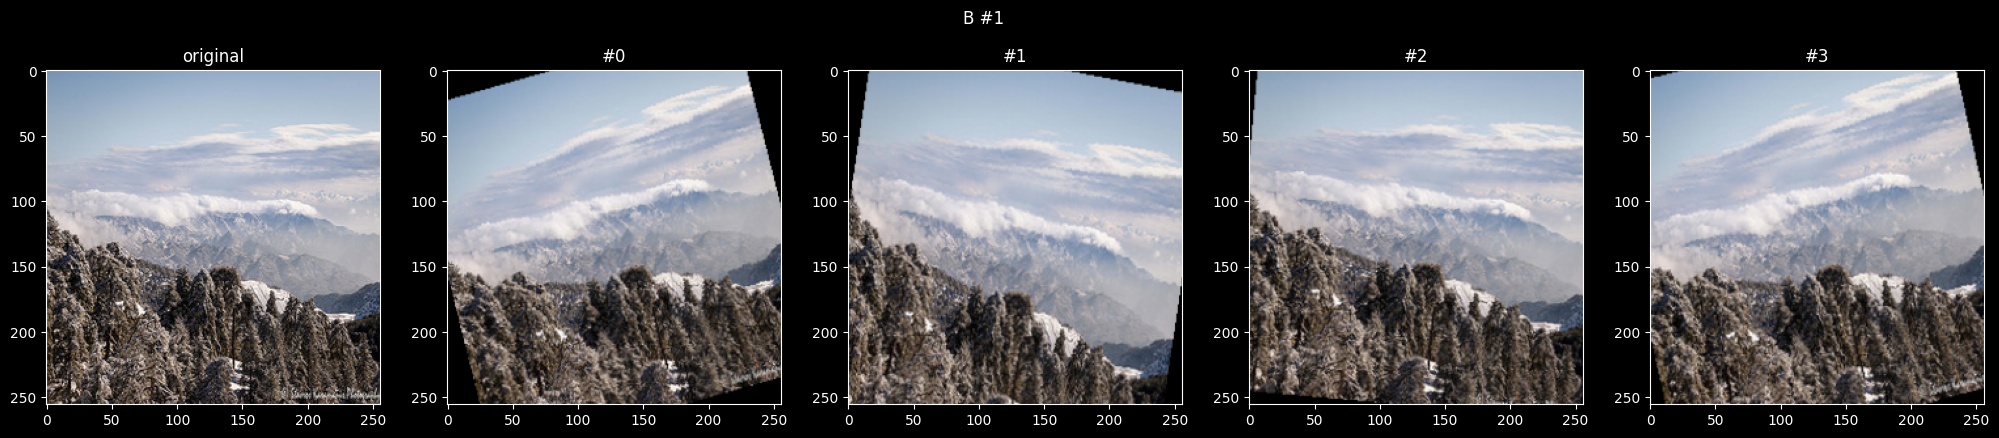

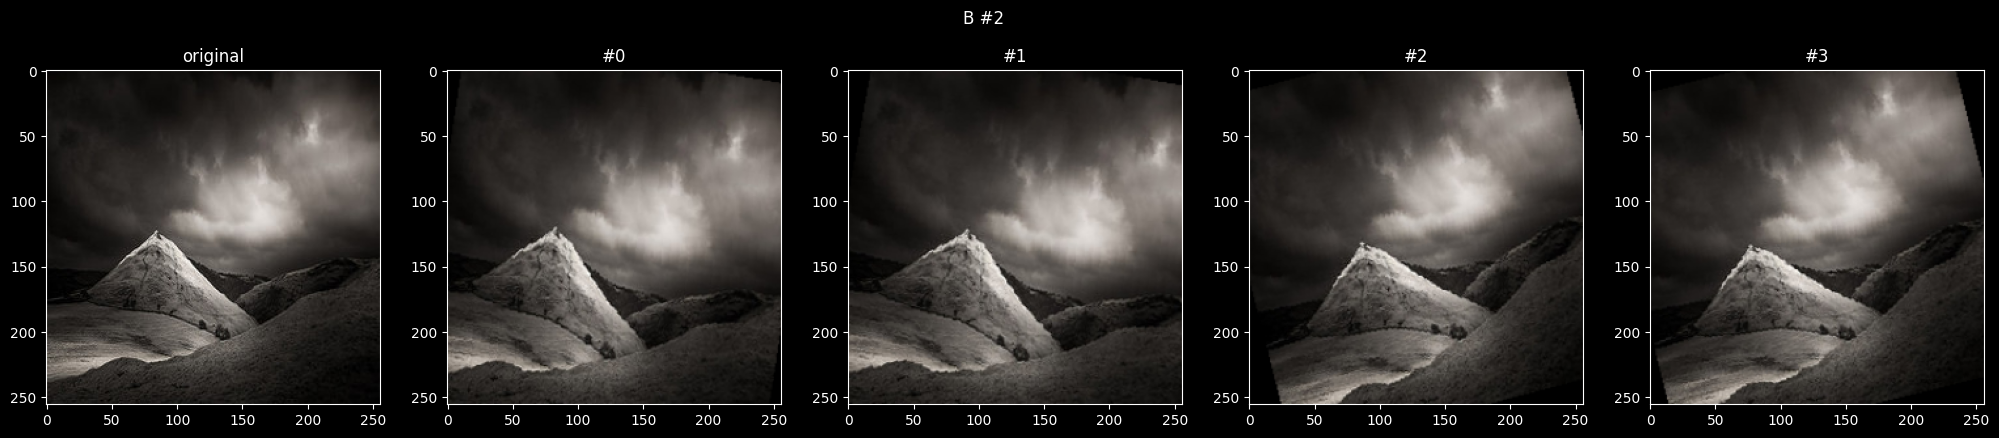

In [7]:
# Функция для получения train и val transform-ов, а так же функции для де-нормализации изображения
def get_transforms(mean, std, img_size):
    train_transform = tr.Compose([
        tr.Resize(img_size),
        tr.RandomRotation(degrees=15),
        tr.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        tr.ToTensor(),
        tr.Normalize(mean, std),
    ])

    test_transform = tr.Compose([
        tr.CenterCrop(img_size),
        tr.ToTensor(),
        tr.Normalize(mean, std)
    ])

    def de_normalize(img):
        copy = img.clone().detach()
        copy = copy.mul_(channel_std_b[:, None, None]).add_(channel_mean_b[:, None, None])
        return copy.permute(1, 2, 0)

    return train_transform, test_transform, de_normalize


# Ваши гиперпараметры
hyperparams = dict(
    img_size = 256
)
# transform-ы для A и B
train_transform_a, val_transform_a, de_normalize_a = get_transforms(channel_mean_a, channel_std_a, **hyperparams)
train_transform_b, val_transform_b, de_normalize_b = get_transforms(channel_mean_b, channel_std_b, **hyperparams)


# Функция для визуализации transform-ов
def show_examples(dataset, transform, de_norm, num_per_image=3, image_index=0, title=""):
    fig, ax = plt.subplots(1, 1 + num_per_image, figsize=(5 * (1 + num_per_image), 5))

    image = dataset[image_index]

    plt.suptitle(title, y=0.95)

    plt.subplot(1, 1 + num_per_image, 1)
    plt.imshow(image)
    plt.title("original")

    for i in range(num_per_image):
        plt.subplot(1, 1 + num_per_image, i + 2)
        plt.title(f"#{i}")
        plt.imshow(de_norm(transform(image)))
    plt.show()

# Проверка на адекватность
show_examples(ds.train_a, train_transform_a, de_normalize_a, num_per_image=4, image_index=0, title="A #0")
show_examples(ds.train_a, val_transform_a, de_normalize_a, num_per_image=1, image_index=0, title="A #0 - val")
show_examples(ds.train_a, train_transform_a, de_normalize_a, num_per_image=4, image_index=1, title="A #1")
show_examples(ds.train_a, train_transform_a, de_normalize_a, num_per_image=4, image_index=2, title="A #2")
show_examples(ds.train_b, train_transform_b, de_normalize_b, num_per_image=4, image_index=0, title="B #0")
show_examples(ds.train_b, val_transform_b, de_normalize_b, num_per_image=1, image_index=0, title="B #0 - val")
show_examples(ds.train_b, train_transform_b, de_normalize_b, num_per_image=4, image_index=1, title="B #1")
show_examples(ds.train_b, train_transform_b, de_normalize_b, num_per_image=4, image_index=2, title="B #2")

In [8]:
# Все датасеты с трансформами
ds = DatasetsClass(
    train_a=ImageDatasetNoLabel(
        os.path.join(target_folder, "trainA"),
        transforms=train_transform_a,
    ),
    train_b=ImageDatasetNoLabel(
        os.path.join(target_folder, "trainB"),
        transforms=val_transform_b,
    ),
    test_a=ImageDatasetNoLabel(
        os.path.join(target_folder, "testA"),
        transforms=val_transform_a,
    ),
    test_b=ImageDatasetNoLabel(
        os.path.join(target_folder, "testB"),
        transforms=val_transform_b,
    ),
)

## 1.3 DataLoader

In [9]:
@dataclass
class DataLoadersClass:
    train_a: DataLoader
    train_b: DataLoader
    test_a: DataLoader
    test_b: DataLoader

batch_size = 5

dataloaders = DataLoadersClass(
    train_a=DataLoader(
        dataset=ds.train_a,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    ),
    train_b=DataLoader(
        dataset=ds.train_b,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    ),
    test_a=DataLoader(
        dataset=ds.test_a,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    ),
    test_b=DataLoader(
        dataset=ds.test_b,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True,
    ),
)

# 2. Модель (___6 баллов___)

## 2.0 Любые вспомогательные модули и классы

In [10]:
from itertools import chain


In [11]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=1, padding=1):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super(Discriminator, self).__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2, inplace=True)
        )
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                Block(in_channels, feature, kernel_size=4, stride=1 if feature == features[-1] else 2, padding=1)
            )
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'))
        self.module = nn.Sequential(*layers)

    def forward(self, x):
        x = self.blocks(x)
        return torch.sigmoid(self.module(x))

    """
    Переопределение метода parameters для корректной работы с оптимизатором
    """
    def parameters(self, recurse: bool = True):
        return self.module.parameters(recurse)

In [12]:
# kwargs - это словарь с параметрами, которые можно передать в nn.Conv2d или nn.ConvTranspose2d, например kernel_size, stride, padding, ...
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode='reflect', **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels,  use_act=False, kernel_size=3, padding=1),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channals, num_features = 64, num_residuals = 9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channals, num_features, kernel_size=7, stride=1, padding=3, padding_mode='reflect'),
            # nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1)
            ]
        )
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features, down=False, kernel_size=3, stride=2, padding=1, output_padding=1)
            ]
        )
        self.last = nn.Conv2d(num_features, img_channals, kernel_size=7, stride=1, padding=3, padding_mode='reflect')

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.residual_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

    def parameters(self, recurse: bool = True):
        return chain(
            self.initial.parameters(recurse),
            self.down_blocks.parameters(recurse),
            self.residual_blocks.parameters(recurse),
            self.up_blocks.parameters(recurse),
            self.last.parameters(recurse)
        )

## 2.1 Архитектура сети (___3 балла___)

In [13]:
class CycleGAN(nn.Module):
    def __init__(self, img_channals, num_features, num_residuals, device='cuda'):
        super(CycleGAN, self).__init__()
        self.gen_AB = Generator(img_channals, num_features, num_residuals)
        self.gen_BA = Generator(img_channals, num_features, num_residuals)
        self.disc_A = Discriminator(img_channals, [num_features, num_features*2, num_features*4, num_features*8])
        self.disc_B = Discriminator(img_channals, [num_features, num_features*2, num_features*4, num_features*8])
        self.device = device

    def forward(self, real_A, real_B):
        fake_A = self.gen_BA(real_B)
        fake_B = self.gen_AB(real_A)
        cycle_A = self.gen_BA(fake_B)
        cycle_B = self.gen_AB(fake_A)
        return fake_A, fake_B, cycle_A, cycle_B

    def gen_forward(self, real_A, real_B):
        fake_B = self.gen_AB(real_A)
        fake_A = self.gen_BA(real_B)
        return fake_A, fake_B

    def disc_forward(self, real_A, real_B):
        disc_A_real = self.disc_A(real_A)
        disc_B_real = self.disc_B(real_B)
        fake_A, fake_B = self.gen_forward(real_A, real_B)
        disc_A_fake = self.disc_A(fake_A)
        disc_B_fake = self.disc_B(fake_B)
        return disc_A_real, disc_B_real, disc_A_fake, disc_B_fake

    def set_gen_AB(self, x):
        return self.gen_AB(x)

    def set_gen_BA(self, x):
        return self.gen_BA(x)

    def set_disc_A(self, x):
        return self.disc_A(x)

    def set_disc_B(self, x):
        return self.disc_B(x)

    def get_disc_A(self):
        return self.disc_A

    def get_disc_B(self):
        return self.disc_B

    def get_gen_AB(self):
        return self.gen_AB

    def get_gen_BA(self):
        return self.gen_BA

    def parameters(self, recurse: bool = True):
        return self.gen_AB.parameters(recurse) + self.gen_BA.parameters(recurse) + self.disc_A.parameters(recurse) + self.disc_B.parameters(recurse)

## 2.2 Loss (___3 балла___)

$$ \mathbf{L}_{\text{cyc}} \big( G_{A \rightarrow B}, G_{B \rightarrow A} \big) = \mathbb{E}_{a \sim A} \bigg( \Big\| G_{B \rightarrow A} \big( G_{A \rightarrow B} ( a ) \big) - a \Big\|_1 \bigg) + \mathbb{E}_{b \sim B} \bigg( \Big\| G_{A \rightarrow B} \big( G_{B \rightarrow A} ( b ) \big) - b \Big\|_1 \bigg) \longrightarrow \min_{G}$$

In [14]:
class CycleConsistencyLoss(nn.Module):
    """
    Функция ошибки, проверяющая что после двойного перехода через генераторы изображение не изменилось
    """
    def __init__(self):
        super(CycleConsistencyLoss, self).__init__()
        self.l1_loss = nn.L1Loss()

    def forward(self, real_image, reconstructed_image):
        return self.l1_loss(real_image, reconstructed_image)

$$ \mathbf{L}_{\text{GAN}} \big( G_{A \rightarrow B}, D_{B} \big) = \mathbb{E}_{b \sim B} \log D_{B} (b) + \mathbb{E}_{a \sim A} \log \Big( 1 - D_{B} \big( G_{A \rightarrow B} (a) \big) \Big) \longrightarrow \min_{G} \max_{D}$$



In [15]:
class AdversarialLossCE(nn.Module):
    """
    Стандартная функция ошибки для minmax игры GAN-ов
    """
    def __init__(self):
        super(AdversarialLossMSE, self).__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, real_pred, fake_pred=None, is_discriminator=True):
        if is_discriminator:
            loss_real = self.loss(real_pred, torch.ones_like(real_pred))
            loss_fake = self.loss(fake_pred, torch.zeros_like(fake_pred))
            return (loss_real + loss_fake) / 2
        else:
            return self.loss(fake_pred, torch.ones_like(fake_pred))

$$ \mathbb{E}_{b \sim B} \big( D_{B} (b) - 1 \big)^2 + \mathbb{E}_{a \sim A} \Big( D_{B} \big( G_{A \rightarrow B} (a) \big) \Big)^2 \longrightarrow \min_{D} $$
$$ \mathbb{E}_{a \sim A} \Big( D_{B} \big( G_{A \rightarrow B} (a) \big) - 1 \Big)^2 \longrightarrow \min_{G} $$

In [16]:
class AdversarialLossMSE(nn.Module):
    """
    Можно переписать не через CE, а через MSE loss на одном предсказании, помогает со стабильностью
    """
    def __init__(self):
        super(AdversarialLossMSE, self).__init__()
        self.loss = nn.MSELoss()

    def forward(self, real_pred, fake_pred, is_discriminator=True):
        # Принимает на вход D_{A}(a) - real_pred и D_{A}(G(b)) - fake_pred или наоборот
        # Может принимать только один аргумент для удобности использования в случае
        #  обучения или генератора, или дискриминатора
        if is_discriminator:
            loss_real = self.loss(real_pred, torch.ones_like(real_pred))
            loss_fake = self.loss(fake_pred, torch.zeros_like(fake_pred))
            return (loss_real + loss_fake) / 2
        else:
            return self.loss(fake_pred, torch.ones_like(fake_pred))


$$ \mathbf{L} \big( G_{A \rightarrow B}, G_{B \rightarrow A}, D_{A}, D_{B} \big) = \mathbf{L}_{\text{GAN}} \big( G_{A \rightarrow B}, D_{B} \big) + \mathbf{L}_{\text{GAN}} \big( G_{B \rightarrow A}, D_{A} \big) + \lambda \cdot \mathbf{L}_{\text{cyc}} \big( G_{A \rightarrow B}, G_{B \rightarrow A} \big) \longrightarrow \min_{G} \max_{D}$$

In [17]:
class FullDiscriminatorLoss(nn.Module):
    """
    Полная ошибка для дискриминатора
    """
    def __init__(self, lambda_cycle=10.0, is_mse=True):
        super(FullDiscriminatorLoss, self).__init__()
        # Choose the adversarial loss type based on the is_mse flag
        if is_mse:
            self.adversarial_loss_func = AdversarialLossMSE()
        else:
            self.adversarial_loss_func = AdversarialLossCE()

        # Cycle consistency loss
        self.cycle_consistency_loss = CycleConsistencyLoss()

        # Weight for cycle consistency loss
        self.lambda_cycle = lambda_cycle

    def forward(self, real_A, fake_B, real_B, fake_A, reconstructed_A, reconstructed_B):
        loss_DB = self.adversarial_loss_func(real_B, fake_B, is_discriminator=True)

        # Adversarial loss for real and fake images from domain A
        loss_DA = self.adversarial_loss_func(real_A, fake_A, is_discriminator=True)

        # Cycle consistency loss
        loss_cycle_A = self.cycle_consistency_loss(reconstructed_A, reconstructed_B)

        # Total cycle consistency loss
        total_cycle_loss = loss_cycle_A

        # Total discriminator loss
        total_loss = loss_DB + loss_DA + self.lambda_cycle * total_cycle_loss
        return total_loss

In [18]:
class FullGeneratorLoss(nn.Module):
    """
    Полная ошибка для генератора
    """
    def __init__(self, lambda_value=10.0, is_mse=True):
        super(FullGeneratorLoss, self).__init__()
        # Selecting the type of adversarial loss based on the user's choice
        if is_mse:
            self.adversarial_loss_func = AdversarialLossMSE()
        else:
            self.adversarial_loss_func = AdversarialLossCE()
        self.cycle_consistency_loss_func = CycleConsistencyLoss()
        self.lambda_value = lambda_value

    def forward(self, real_A, fake_B, real_B, fake_A, reconstructed_A, reconstructed_B):
        adv_loss_AtoB = self.adversarial_loss_func(None, fake_B, is_discriminator=False)
        adv_loss_BtoA = self.adversarial_loss_func(None, fake_A, is_discriminator=False)

        cycle_loss_A = self.cycle_consistency_loss_func(real_A, reconstructed_B)
        cycle_loss_B = self.cycle_consistency_loss_func(real_B, reconstructed_A)

        total_loss = adv_loss_AtoB + adv_loss_BtoA + self.lambda_value * (cycle_loss_A + cycle_loss_B)
        return total_loss

# 3. Подготовка обучения (__2 балла__)

## 3.1 Шаг обучения дискриминатора

In [19]:
def train_discriminators(model, opt_d, loader_a, loader_b, criterion_d):
    model.train()
    total_loss = 0

    for real_a, real_b in zip(loader_a, loader_b):
        real_a = real_a.to(model.device)
        real_b = real_b.to(model.device)

        fake_a = model.set_gen_BA(real_b)
        fake_b = model.set_gen_AB(real_a)

        disc_real_a = model.set_disc_A(real_a)
        disc_real_b = model.set_disc_B(real_b)

        disc_fake_a = model.set_disc_A(fake_a)
        disc_fake_b = model.set_disc_B(fake_b)

        print("real_a: ", real_a.shape)
        print("fake_a: ", fake_a.shape)
        print("fake_b: ", fake_b.shape)
        print("real_b: ", real_b.shape)
        print("disc_real_a: ", disc_real_a.shape)
        print("disc_fake_a: ", disc_fake_a.shape)
        print("disc_real_b: ", disc_real_b.shape)
        print("disc_fake_b: ", disc_fake_b.shape)
        loss_d_a = criterion_d(real_a, fake_b, real_b, fake_a, disc_real_a, disc_fake_b)
        loss_d_b = criterion_d(real_a, fake_b, real_b, fake_a, disc_real_b, disc_fake_a)
        loss_d = (loss_d_a + loss_d_b) / 2

        opt_d.zero_grad()
        loss_d.backward()
        opt_d.step()

        total_loss += loss_d.item()

    return total_loss / max(len(loader_a), len(loader_b))

## 3.2 Шаг обучения генератора

In [20]:
def train_generators(model, opt_g, loader_a, loader_b, criterion_g):
    model.train()
    total_loss = 0

    for real_a, real_b in zip(loader_a, loader_b):
        real_a = real_a.to(model.device)
        real_b = real_b.to(model.device)

        fake_a = model.set_gen_BA(real_b)
        fake_b = model.set_gen_AB(real_a)
        
        rec_a = model.set_gen_BA(fake_b)
        rec_b = model.set_gen_AB(fake_a)

        gen_loss_a = criterion_g(real_a, fake_b, real_b, fake_a, rec_a, rec_b)
        gen_loss_b = criterion_g(real_a, fake_b, real_b, fake_a, rec_a, rec_b)
        gen_loss = (gen_loss_a + gen_loss_b) / 2

        opt_g.zero_grad()
        gen_loss.backward()
        opt_g.step()

        total_loss += gen_loss.item()

    return total_loss / max(len(loader_a), len(loader_b))

## 3.3 Шаг валидации

In [21]:
from collections import defaultdict

def val(model, loader_a, loader_b, criterion_d, criterion_g):
    model.eval()

    val_data = defaultdict(list)

    with torch.no_grad():
        iter_a = iter(loader_a)
        iter_b = iter(loader_b)
        batches_per_epoch = min(len(iter_a), len(iter_b))

        for _ in trange(batches_per_epoch):
            real_a = next(iter_a).to(model.device)
            real_b = next(iter_b).to(model.device)

            # Generate fake images
            fake_a = model.set_gen_BA(real_b)
            fake_b = model.set_gen_AB(real_a)

            # Calculate the discriminator losses on the real and fake images
            disc_real_a = model.set_disc_A(real_a)
            disc_real_b = model.set_disc_B(real_b)
            disc_fake_a = model.set_disc_A(fake_a)
            disc_fake_b = model.set_disc_B(fake_b)

            loss_d_a = criterion_d(disc_real_a, disc_fake_a)
            loss_d_b = criterion_d(disc_real_b, disc_fake_b)
            loss_d = (loss_d_a + loss_d_b) / 2

            # Calculate the generator losses on the real and fake images
            gen_loss_a = criterion_g(real_a, fake_a)
            gen_loss_b = criterion_g(real_b, fake_b)
            gen_loss = (gen_loss_a + gen_loss_b) / 2

            val_data["loss D"].append(loss_d.item())
            val_data["loss G"].append(gen_loss.item())

            # Log the predictions
            is_mse_pred = disc_real_a.shape[-1] == 1

            if is_mse_pred:
                a_real_pred = disc_real_a[:, 0]
                b_real_pred = disc_real_b[:, 0]
                a_fake_pred = disc_fake_a[:, 0]
                b_fake_pred = disc_fake_b[:, 0]
            else:
                a_real_pred = torch.softmax(disc_real_a, dim=1)[:, 1]
                b_real_pred = torch.softmax(disc_real_b, dim=1)[:, 1]
                a_fake_pred = torch.softmax(disc_fake_a, dim=1)[:, 1]
                b_fake_pred = torch.softmax(disc_fake_b, dim=1)[:, 1]

            val_data["real pred A"].extend(a_real_pred.cpu().detach().tolist())
            val_data["real pred B"].extend(b_real_pred.cpu().detach().tolist())
            val_data["fake pred A"].extend(a_fake_pred.cpu().detach().tolist())
            val_data["fake pred B"].extend(b_fake_pred.cpu().detach().tolist())

        val_data["loss D"] = np.mean(val_data["loss D"])
        val_data["loss G"] = np.mean(val_data["loss G"])

    return val_data

## 3.4 Визуализация сгенерированного

In [22]:
def draw_imgs(model, num_images, loader_a, loader_b, de_norm_a, de_norm_b):
    model.eval()
    with torch.no_grad():
        imgs_a = next(iter(loader_a))[:num_images].to(device)
        imgs_b = next(iter(loader_b))[:num_images].to(device)

        fake_b = model.translate_a_to_b(imgs_a)  # Translates domain A to B
        fake_a = model.translate_b_to_a(imgs_b)  # Translates domain B to A
        rec_a = model.reconstruct_a(imgs_a)  # Reconstructs A from translated B
        rec_b = model.reconstruct_b(imgs_b)  # Reconstructs B from translated A

    # Draw num_images examples for A
        fig, ax = plt.subplots(num_images, 3, figsize=(25, 15))
        plt.suptitle("Images from A", y=0.92)

        for ind in range(num_images):
            plt.subplot(num_images, 3, ind * 3 + 1)
            plt.title("Original from A")
            plt.imshow(de_norm_a(imgs_a[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 2)
            plt.title("Translated to B")
            plt.imshow(de_norm_b(fake_b[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 3)
            plt.title("Reconstructed A")
            plt.imshow(de_norm_a(rec_a[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])

        # Draw num_images examples for B
        fig, ax = plt.subplots(num_images, 3, figsize=(25, 15))
        plt.suptitle("Images from B", y=0.92)

        for ind in range(num_images):
            plt.subplot(num_images, 3, ind * 3 + 1)
            plt.title("Original from B")
            plt.imshow(de_norm_b(imgs_b[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 2)
            plt.title("Translated to A")
            plt.imshow(de_norm_a(fake_a[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])

            plt.subplot(num_images, 3, ind * 3 + 3)
            plt.title("Reconstructed B")
            plt.imshow(de_norm_b(rec_b[ind], normalized=True))
            plt.xticks([])
            plt.yticks([])

        plt.show()

## 3.5 Цикл обучения

In [23]:
from IPython.display import clear_output
import warnings

def get_model_name(chkp_folder, model_name=None):
    # Выбираем имя чекпоинта для сохранения
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    else:
        if "#" not in model_name:
            model_name += "#0"
    changed = False
    while os.path.exists(os.path.join(chkp_folder, model_name + '.pt')):
        model_name, ind = model_name.split("#")
        model_name += f"#{int(ind) + 1}"
        changed=True
    if changed:
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    return model_name


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_loop(
    model,
    optimizer_g,
    g_iters_per_epoch,
    optimizer_d,
    d_iters_per_epoch,
    train_loader_a,
    train_loader_b,
    val_loader_a,
    val_loader_b,
    criterion_d,
    criterion_g,
    de_norm_a,
    de_norm_b,
    scheduler_d=None,
    scheduler_g=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    model_name=None,
    chkp_folder="./chkps",
    images_per_validation=3,
    plots=None,
    starting_epoch=0,
):
    model_name = get_model_name(chkp_folder, model_name)

    if plots is None:
        plots = {
            'train G': [],
            'train D': [],
            'val D': [],
            'val G': [],
            "lr G": [],
            "lr D": [],
            "hist real A": [],
            "hist gen A": [],
            "hist real B": [],
            "hist gen B": [],
        }

    for epoch in np.arange(1, epochs+1) + starting_epoch:
        print(f'#{epoch}/{epochs}:')

        plots['lr G'].append(get_lr(optimizer_g))
        plots['lr D'].append(get_lr(optimizer_d))

        # train discriminators
        print(f"train discriminators ({d_iters_per_epoch} times)")
        loss_d = []
        for _ in range(d_iters_per_epoch):
            loss = train_discriminators(model, optimizer_d, train_loader_a, train_loader_b, criterion_d)
            loss_d.append(loss)
        plots['train D'].extend(loss_d)

        # train generators
        print(f"train generators ({g_iters_per_epoch} times)")
        loss_g = []
        for _ in range(g_iters_per_epoch):
            loss = train_generators(model, optimizer_g, train_loader_a, train_loader_b, criterion_g)
            loss_g.append(loss)
        plots['train G'].extend(loss_g)

        if not (epoch % val_every):
            print("validate")
            val_data = val(model, val_loader_a, val_loader_b, criterion_d, criterion_g)
            plots['val D'].append(val_data["loss D"])
            plots['val G'].append(val_data["loss G"])
            plots['hist real A'].append(val_data["real pred A"])
            plots['hist gen A'].append(val_data["fake pred A"])
            plots['hist real B'].append(val_data["real pred B"])
            plots['hist gen B'].append(val_data["fake pred B"])

            # Сохраняем модель
            if not os.path.exists(chkp_folder):
                os.makedirs(chkp_folder)
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_d_state_dict': optimizer_d.state_dict(),
                    'optimizer_g_state_dict': optimizer_g.state_dict(),
                    'scheduler_d_state_dict': scheduler_d.state_dict(),
                    'scheduler_g_state_dict': scheduler_g.state_dict(),
                    'plots': plots,
                },
                os.path.join(chkp_folder, model_name + '.pt'),
            )

            # Шедулинг
            if scheduler_d:
                try:
                    scheduler_d.step()
                except:
                    scheduler_d.step(loss_d)
            if scheduler_g:
                try:
                    scheduler_g.step()
                except:
                    scheduler_g.step(loss_g)

        if not (epoch % draw_every):
            clear_output(True)

            hh = 2
            ww = 2
            plt_ind = 1
            fig, ax = plt.subplots(hh, ww, figsize=(25, 12))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(hh, ww, plt_ind)
            plt.title('discriminators losses')
            d_plot_step = 1. / d_iters_per_epoch
            plt.plot(np.arange(d_plot_step, epoch + d_plot_step, d_plot_step), plots['train D'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val D'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title('generators losses')
            g_plot_step = 1. / g_iters_per_epoch
            plt.plot(np.arange(g_plot_step, epoch + g_plot_step, g_plot_step), plots['train G'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val G'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1

            # plt.subplot(hh, ww, plt_ind)
            # plt.title('learning rates')
            # plt.plot(plots["lr D"], 'b.-', label='lr discriminator', alpha=0.7)
            # plt.plot(plots["lr G"], 'm.-', label='lr generator', alpha=0.7)
            # plt.legend()
            # plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title("Discriminator A predictions")
            plt.hist(plots["hist real A"][-1], bins=50, density=True, label="real", color="green", alpha=0.7)
            plt.hist(plots["hist gen A"][-1], bins=50, density=True, label="generated", color="red", alpha=0.7)
            plt.xlim((-0.05, 1.05))
            plt.xticks(ticks=np.arange(0, 1.05, 0.1))
            plt.legend()
            plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title("Discriminator B predictions")
            plt.hist(plots["hist real B"][-1], bins=50, density=True, label="real", color="green", alpha=0.7)
            plt.hist(plots["hist gen B"][-1], bins=50, density=True, label="generated", color="red", alpha=0.7)
            plt.xlim((-0.05, 1.05))
            plt.xticks(ticks=np.arange(0, 1.05, 0.1))
            plt.legend()
            plt_ind += 1

            plt.show()

            draw_imgs(model, images_per_validation, val_loader_a, val_loader_b, de_norm_a, de_norm_b)


        if min_lr and get_lr(optimizer_d) <= min_lr:
            print(f'Learning process ended with early stop for discriminator after epoch {epoch}')
            break

        if min_lr and get_lr(optimizer_g) <= min_lr:
            print(f'Learning process ended with early stop for generator after epoch {epoch}')
            break

    return model, optimizer_d, optimizer_g, plots

# 4. Обучение (___2 балла___)

## 4.1 Инициализация модели и оптимайзера

In [24]:
from collections import defaultdict
from termcolor import colored


def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))


# Подсчёт числа параметров в нашей модели
def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    submodules = defaultdict(lambda : [0, 0])
    for name, param in model.named_parameters():
        num_params = param.numel()
        if verbose_all or (verbose_only_learnable and param.requires_grad):
            print(
                colored(
                    '{: <65} ~  {: <9} params ~ grad: {}'.format(
                        name,
                        beautiful_int(num_params),
                        param.requires_grad,
                    ),
                    {True: "green", False: "red"}[param.requires_grad],
                )
            )
        sum_params += num_params
        sm = name.split(".")[0]
        submodules[sm][0] += num_params
        if param.requires_grad:
            sum_learnable_params += num_params
            submodules[sm][1] += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )

    for sm, v in submodules.items():
        print(
            f"\n . {sm}:\n .   - {beautiful_int(submodules[sm][0])} params\n .   - {beautiful_int(submodules[sm][1])} learnable params"
        )
    return sum_params, sum_learnable_params

In [25]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, lr=1e-3, device=device):
    model = model_class(**model_params)
    model = model.to(device)

    optimizer_d = torch.optim.Adam(
        model.disc_A.parameters(),
        lr=lr,
    )
    optimizer_g = torch.optim.Adam(
        model.gen_AB.parameters(),
        lr=lr,
    )
    return model, optimizer_d, optimizer_g

## 4.2 Фактическое обучение

In [26]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

results = []
model_params = {
    "img_channals": 3,
    "num_features": 64,
    "num_residuals": 9,
    "device": device,
}
model, optimizer_d, optimizer_g = create_model_and_optimizer(
    model_class = CycleGAN,
    model_params = model_params,
    lr = 1e-3,
    device = device,
)


scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_d, step_size=30, gamma=0.1)
scheduler_g = torch.optim.lr_scheduler.StepLR(optimizer_g, step_size=30, gamma=0.1)

criterion_d = FullDiscriminatorLoss(lambda_cycle=10.0, is_mse=True)
criterion_g = FullGeneratorLoss(lambda_value=10.0, is_mse=True)

sum_params, sum_learnable_params = model_num_params(model)

gen_AB.initial.0.weight                                           ~  9.408     params ~ grad: True
gen_AB.initial.0.bias                                             ~  64        params ~ grad: True
gen_AB.down_blocks.0.conv.0.weight                                ~  73.728    params ~ grad: True
gen_AB.down_blocks.0.conv.0.bias                                  ~  128       params ~ grad: True
gen_AB.down_blocks.1.conv.0.weight                                ~  294.912   params ~ grad: True
gen_AB.down_blocks.1.conv.0.bias                                  ~  256       params ~ grad: True
gen_AB.residual_blocks.0.block.0.conv.0.weight                    ~  589.824   params ~ grad: True
gen_AB.residual_blocks.0.block.0.conv.0.bias                      ~  256       params ~ grad: True
gen_AB.residual_blocks.0.block.1.conv.0.weight                    ~  589.824   params ~ grad: True
gen_AB.residual_blocks.0.block.1.conv.0.bias                      ~  256       params ~ grad: True
gen_AB.res

In [27]:
model

CycleGAN(
  (gen_AB): Generator(
    (initial): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
      (1): ReLU(inplace=True)
    )
    (down_blocks): ModuleList(
      (0): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
          (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
      )
      (1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
          (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
      )
    )
    (residual_blocks): Sequential(
      (0): ResidualBlock(
        (block): Sequential(
          (0): ConvBlock(
            (conv): Sequential(
      

In [28]:
%%time
model, optimizer_d, optimizer_g, plots = learning_loop(
    model = model,
    optimizer_g = optimizer_g,
    g_iters_per_epoch = 1,
    optimizer_d = optimizer_d,
    d_iters_per_epoch = 1,
    train_loader_a = dataloaders.train_a,
    train_loader_b = dataloaders.train_b,
    val_loader_a = dataloaders.test_a,
    val_loader_b = dataloaders.test_b,
    criterion_d = criterion_d,
    criterion_g = criterion_g,
    scheduler_g = scheduler_g,
    scheduler_d = scheduler_d,
    de_norm_a = de_normalize_a,
    de_norm_b = de_normalize_b,
    epochs = 100,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    chkp_folder = "./chkp",
    model_name = "cycle_gan",
    images_per_validation=3,
    plots=None,
    starting_epoch=0,
)

#1/100:
train discriminators (1 times)
real_a:  torch.Size([5, 3, 256, 256])
fake_a:  torch.Size([5, 3, 256, 256])
fake_b:  torch.Size([5, 3, 256, 256])
real_b:  torch.Size([5, 3, 256, 256])
disc_real_a:  torch.Size([5, 1, 30, 30])
disc_fake_a:  torch.Size([5, 1, 30, 30])
disc_real_b:  torch.Size([5, 1, 30, 30])
disc_fake_b:  torch.Size([5, 1, 30, 30])
real_a:  torch.Size([5, 3, 256, 256])
fake_a:  torch.Size([5, 3, 256, 256])
fake_b:  torch.Size([5, 3, 256, 256])
real_b:  torch.Size([5, 3, 256, 256])
disc_real_a:  torch.Size([5, 1, 30, 30])
disc_fake_a:  torch.Size([5, 1, 30, 30])
disc_real_b:  torch.Size([5, 1, 30, 30])
disc_fake_b:  torch.Size([5, 1, 30, 30])
real_a:  torch.Size([5, 3, 256, 256])
fake_a:  torch.Size([5, 3, 256, 256])
fake_b:  torch.Size([5, 3, 256, 256])
real_b:  torch.Size([5, 3, 256, 256])
disc_real_a:  torch.Size([5, 1, 30, 30])
disc_fake_a:  torch.Size([5, 1, 30, 30])
disc_real_b:  torch.Size([5, 1, 30, 30])
disc_fake_b:  torch.Size([5, 1, 30, 30])
real_a:  torc

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 5.80 GiB of which 4.75 MiB is free. Process 57220 has 558.00 MiB memory in use. Including non-PyTorch memory, this process has 5.23 GiB memory in use. Of the allocated memory 4.90 GiB is allocated by PyTorch, and 194.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [29]:
model

CycleGAN(
  (gen_AB): Generator(
    (initial): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
      (1): ReLU(inplace=True)
    )
    (down_blocks): ModuleList(
      (0): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
          (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
      )
      (1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
          (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
        )
      )
    )
    (residual_blocks): Sequential(
      (0): ResidualBlock(
        (block): Sequential(
          (0): ConvBlock(
            (conv): Sequential(
      

In [30]:
%%time
model, optimizer_d, optimizer_g, plots = learning_loop(
    model = model,
    optimizer_g = optimizer_g,
    g_iters_per_epoch = 1,
    optimizer_d = optimizer_d,
    d_iters_per_epoch = 1,
    train_loader_a = dataloaders.train_a,
    train_loader_b = dataloaders.train_b,
    val_loader_a = dataloaders.test_a,
    val_loader_b = dataloaders.test_b,
    criterion_d = criterion_d,
    criterion_g = criterion_g,
    scheduler_g = scheduler_g,
    scheduler_d = scheduler_d,
    de_norm_a = de_normalize_a,
    de_norm_b = de_normalize_b,
    epochs = 100,
    min_lr = 1e-6,
    val_every = 1,
    draw_every = 1,
    chkp_folder = "./chkp",
    model_name = "cycle_gan",
    images_per_validation=3,
    plots=None,
    starting_epoch=0,
)

#1/100:
train discriminators (1 times)


OutOfMemoryError: CUDA out of memory. Tried to allocate 80.00 MiB. GPU 0 has a total capacity of 5.80 GiB of which 4.75 MiB is free. Process 57220 has 558.00 MiB memory in use. Including non-PyTorch memory, this process has 5.23 GiB memory in use. Of the allocated memory 4.91 GiB is allocated by PyTorch, and 182.99 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

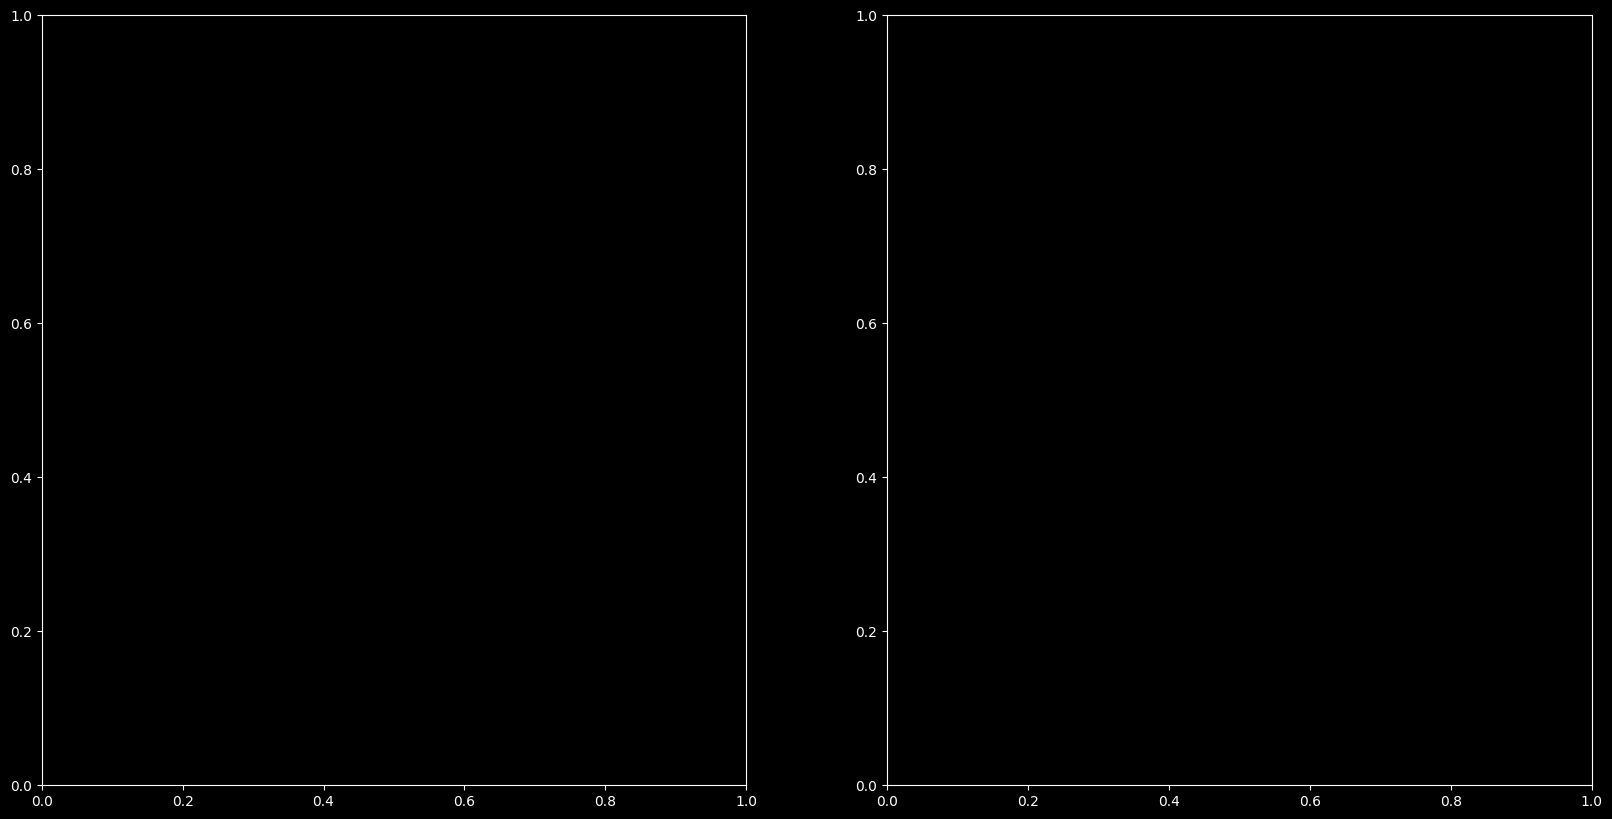

In [31]:
img_a = ds.test_a[1].to(device).unsqueeze(0)

plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(121)
plt.imshow(de_normalize_a(img_a[0]))

plt.subplot(122)
plt.imshow(de_normalize_b(model.generators["a_to_b"](img_a)[0]))

plt.show()

In [ ]:
img_a = ds.test_a[5].to(device).unsqueeze(0)

plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(121)
plt.imshow(de_normalize_a(img_a[0]))

plt.subplot(122)
plt.imshow(de_normalize_b(model.generators["a_to_b"](img_a)[0]))

plt.show()

In [ ]:
img_ind = 1
img_a = ds.test_a[img_ind].to(device).unsqueeze(0)
fake_b = ...(img_a)...

plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(121)
plt.imshow(de_normalize_a(img_a[0]))

plt.subplot(122)
plt.imshow(de_normalize_b(fake_b))

plt.show()

In [ ]:
img_ind = 0
img_b = ds.test_b[img_ind].to(device).unsqueeze(0)
fake_a = ...(img_b)...

plt.subplots(1, 2, figsize=(20, 10))

plt.subplot(121)
plt.imshow(de_normalize_b(img_b[0]))

plt.subplot(122)
plt.imshow(de_normalize_a(fake_a))

plt.show()

# 5. Свои данные (___3 балла + бонусы___)

В этой части нужно сделать следующее:

* Собрать свой один или пару небольших датасетов (хотя бы 100 примеров, но чем больше тем лучше у вас будет качество финальной модели) - формально ограничений нет, но давайте без чего-то неадекватного или за рамками
* Обучить модель CycleGAN между вашим датасетом и каким-то ещё (либо так же вашим, либо любым существующим - полностью на вашу фантазию)
* Для сдачи задания - требуется
    * приложить ссылку на заархивированный датасет, на котором вы обучались
    * в ноутбуке сделать наглядную визуализацию данных из A и B (желательно с текстовым описанием вашей задумки)
    * в ноутбуке иметь код обучения вашей модели
    * в ноутбуке иметь визуальные результаты работы вашей модели (A в B и B в A - хотя бы по 5 примеров на каждый)
* __Задание предполагает возможность получения дополнительных баллов сверх стоимости домашки за интересные и качественные датасеты, а так же модели высокого качества__

___Удачи!___